In [1]:
pip install mesa==0.8.7

Note: you may need to restart the kernel to use updated packages.


20it [00:41,  2.10s/it]
20it [00:53,  2.66s/it]
20it [00:28,  1.44s/it]
0it [00:00, ?it/s]C:\Users\alext\Documents\GitHub\Epi-Simulator\Epi-Simulator\Simulator\Agent.py:40: RuntimeWarning: divide by zero encountered in log
  self.recovery_rate = min(1, np.random.lognormal(np.log(model.recovery_rate), 0.7))
20it [00:28,  1.45s/it]
20it [02:33,  7.67s/it]
20it [00:27,  1.39s/it]
20it [00:28,  1.41s/it]
20it [00:26,  1.34s/it]
20it [00:29,  1.47s/it]
0it [00:00, ?it/s]C:\Users\alext\Documents\GitHub\Epi-Simulator\Epi-Simulator\Simulator\Agent.py:40: RuntimeWarning: divide by zero encountered in log
  self.recovery_rate = min(1, np.random.lognormal(np.log(model.recovery_rate), 0.7))
20it [00:28,  1.45s/it]
20it [02:36,  7.80s/it]
20it [00:27,  1.36s/it]
20it [00:16,  1.24it/s]
20it [00:19,  1.04it/s]
20it [00:17,  1.12it/s]
0it [00:00, ?it/s]C:\Users\alext\Documents\GitHub\Epi-Simulator\Epi-Simulator\Simulator\Agent.py:40: RuntimeWarning: divide by zero encountered in log
  self.recovery_r

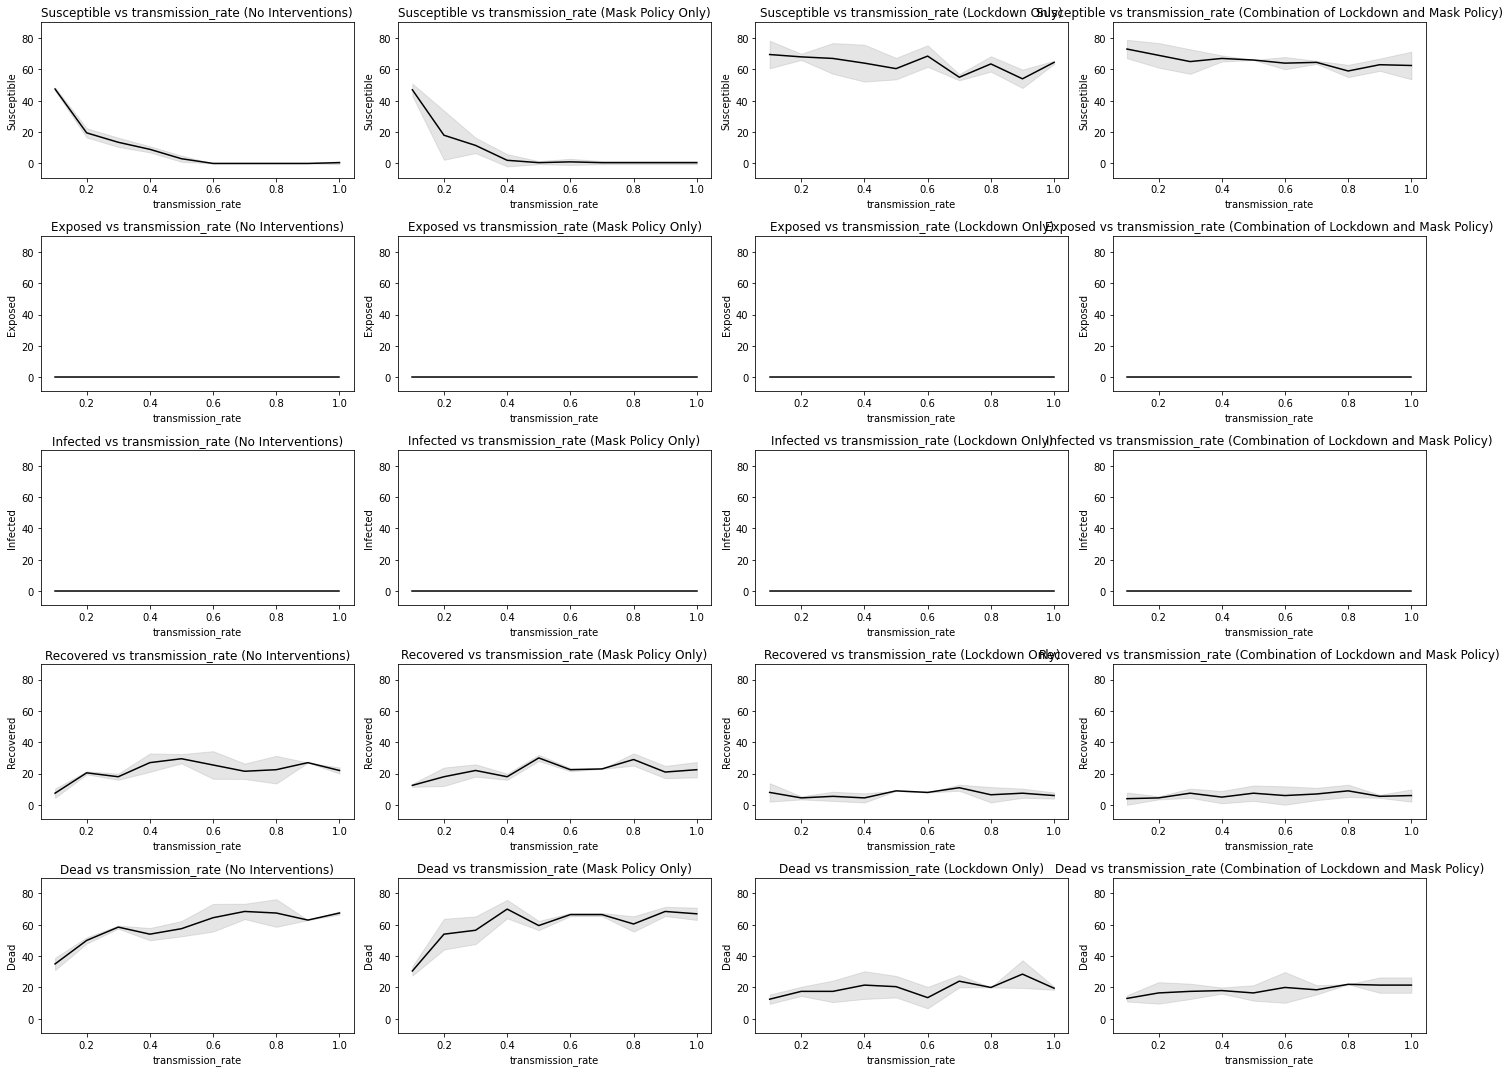

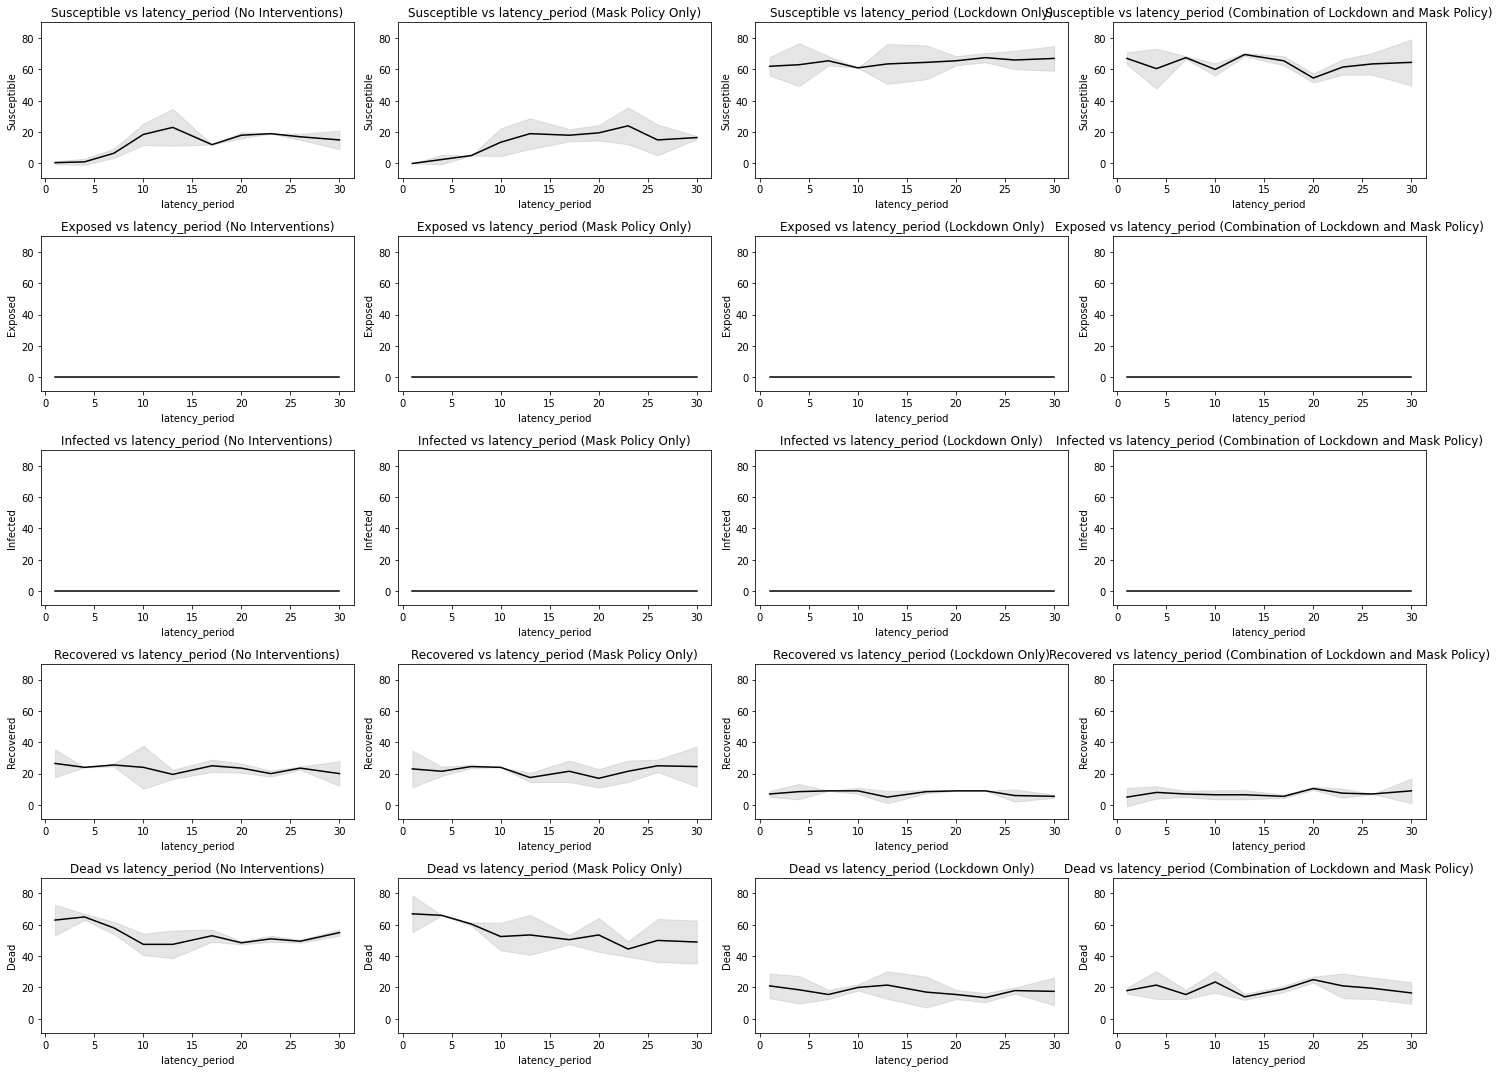

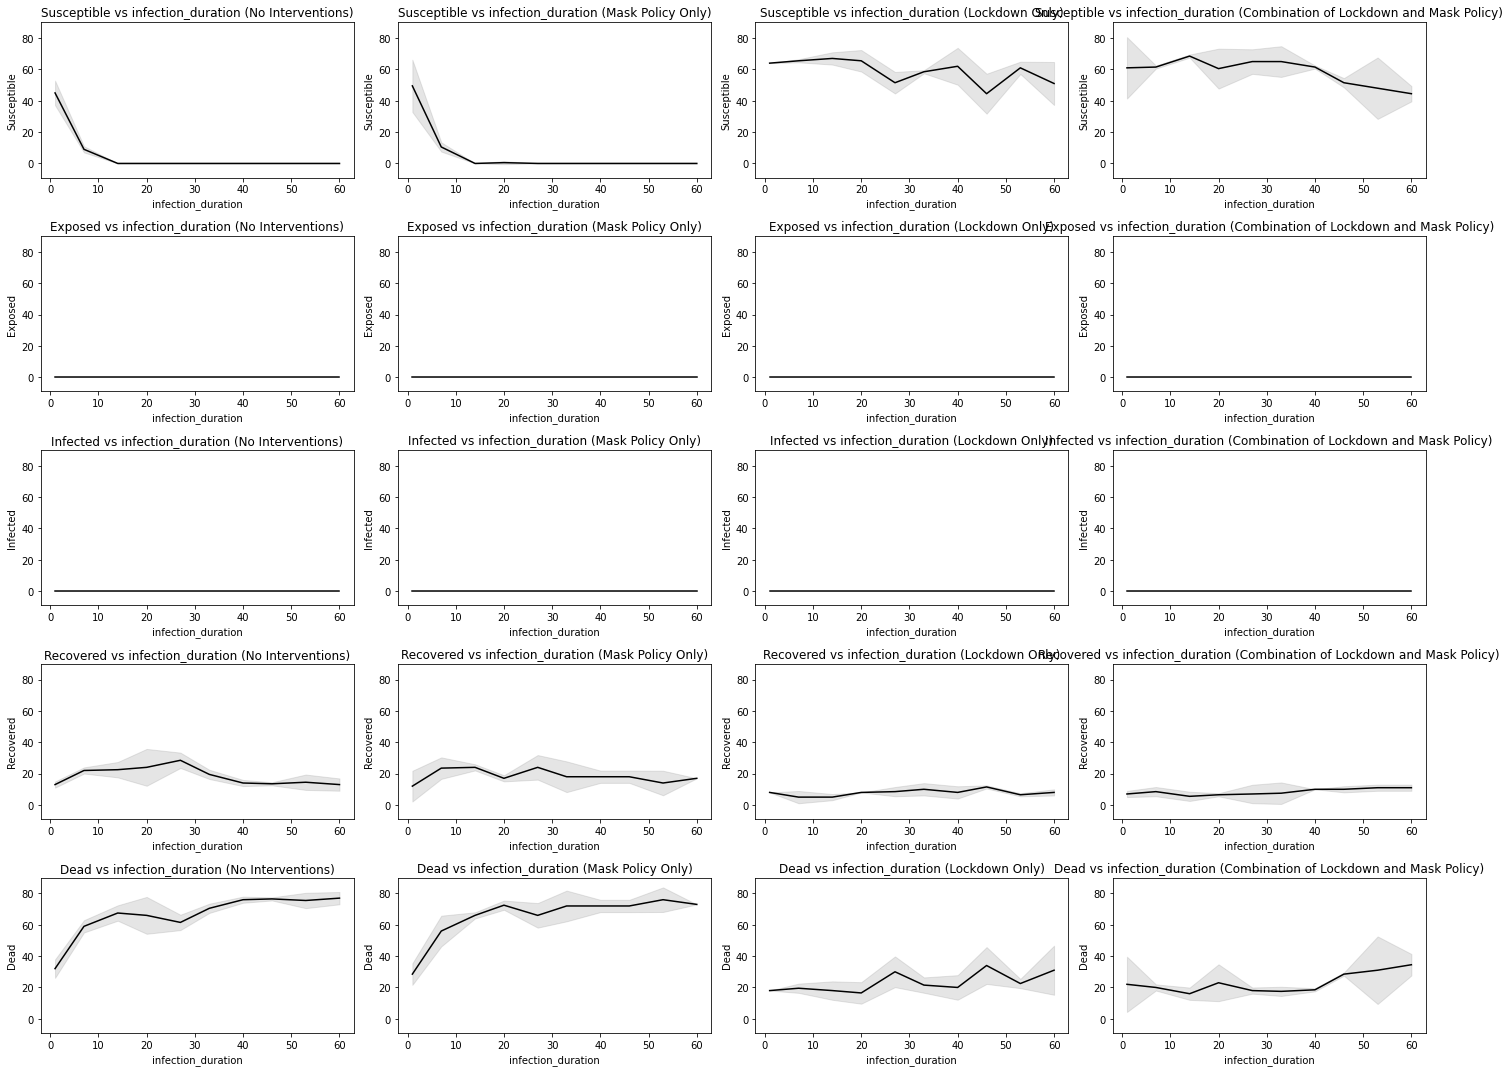

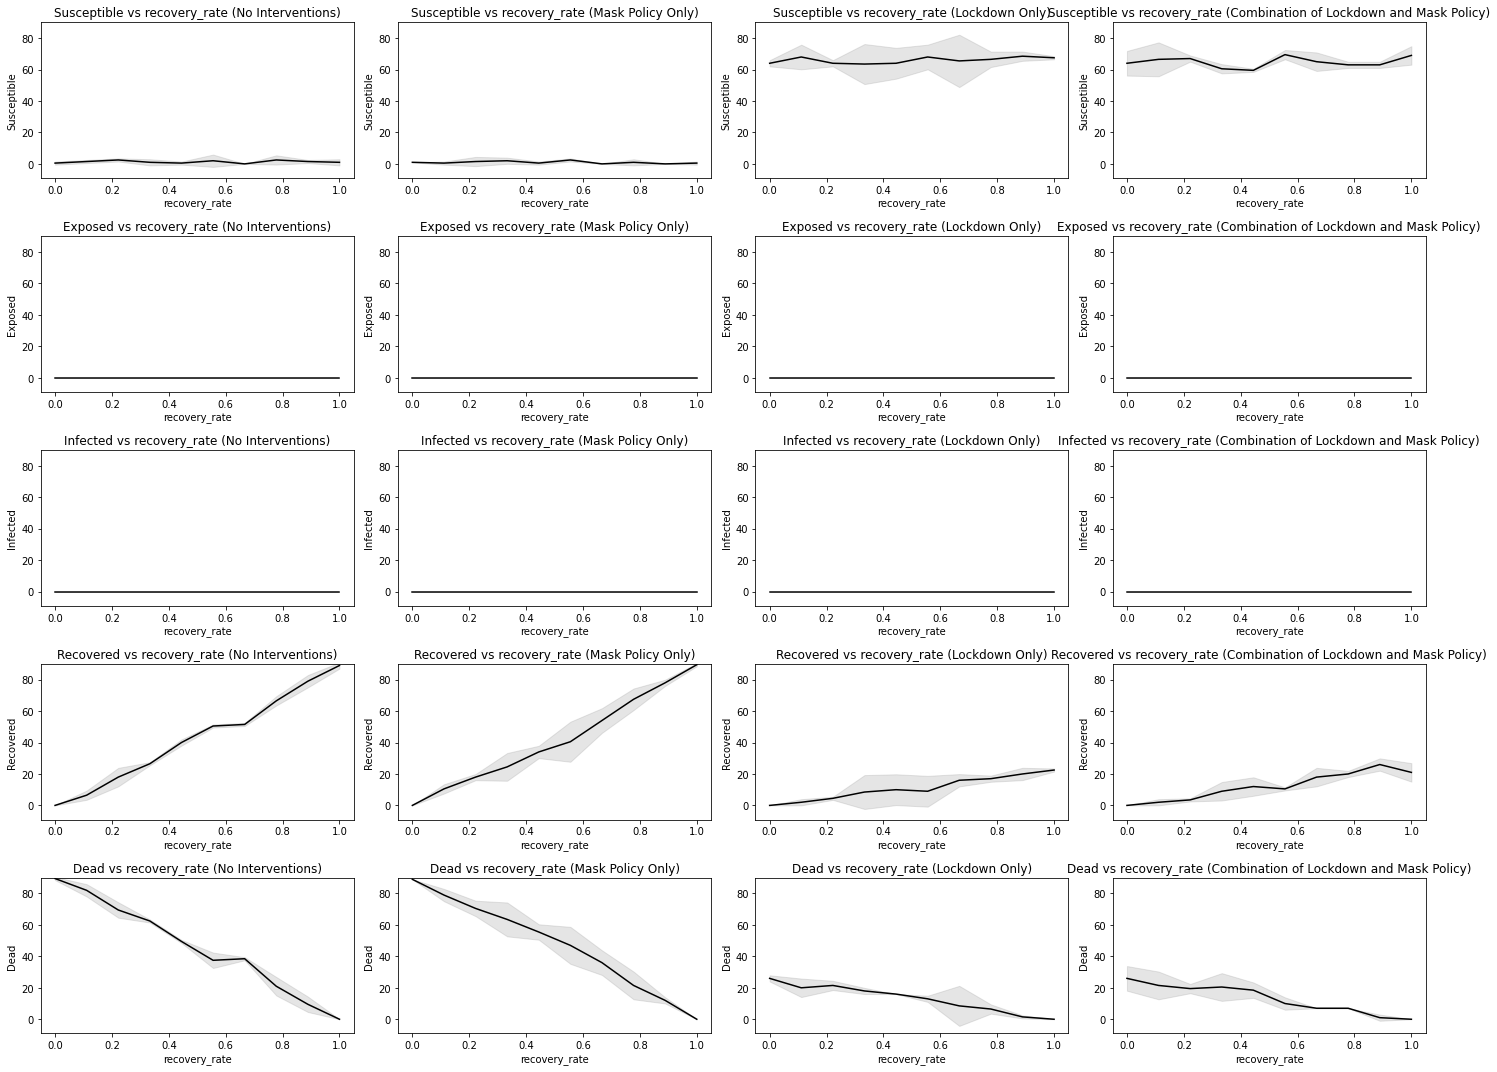

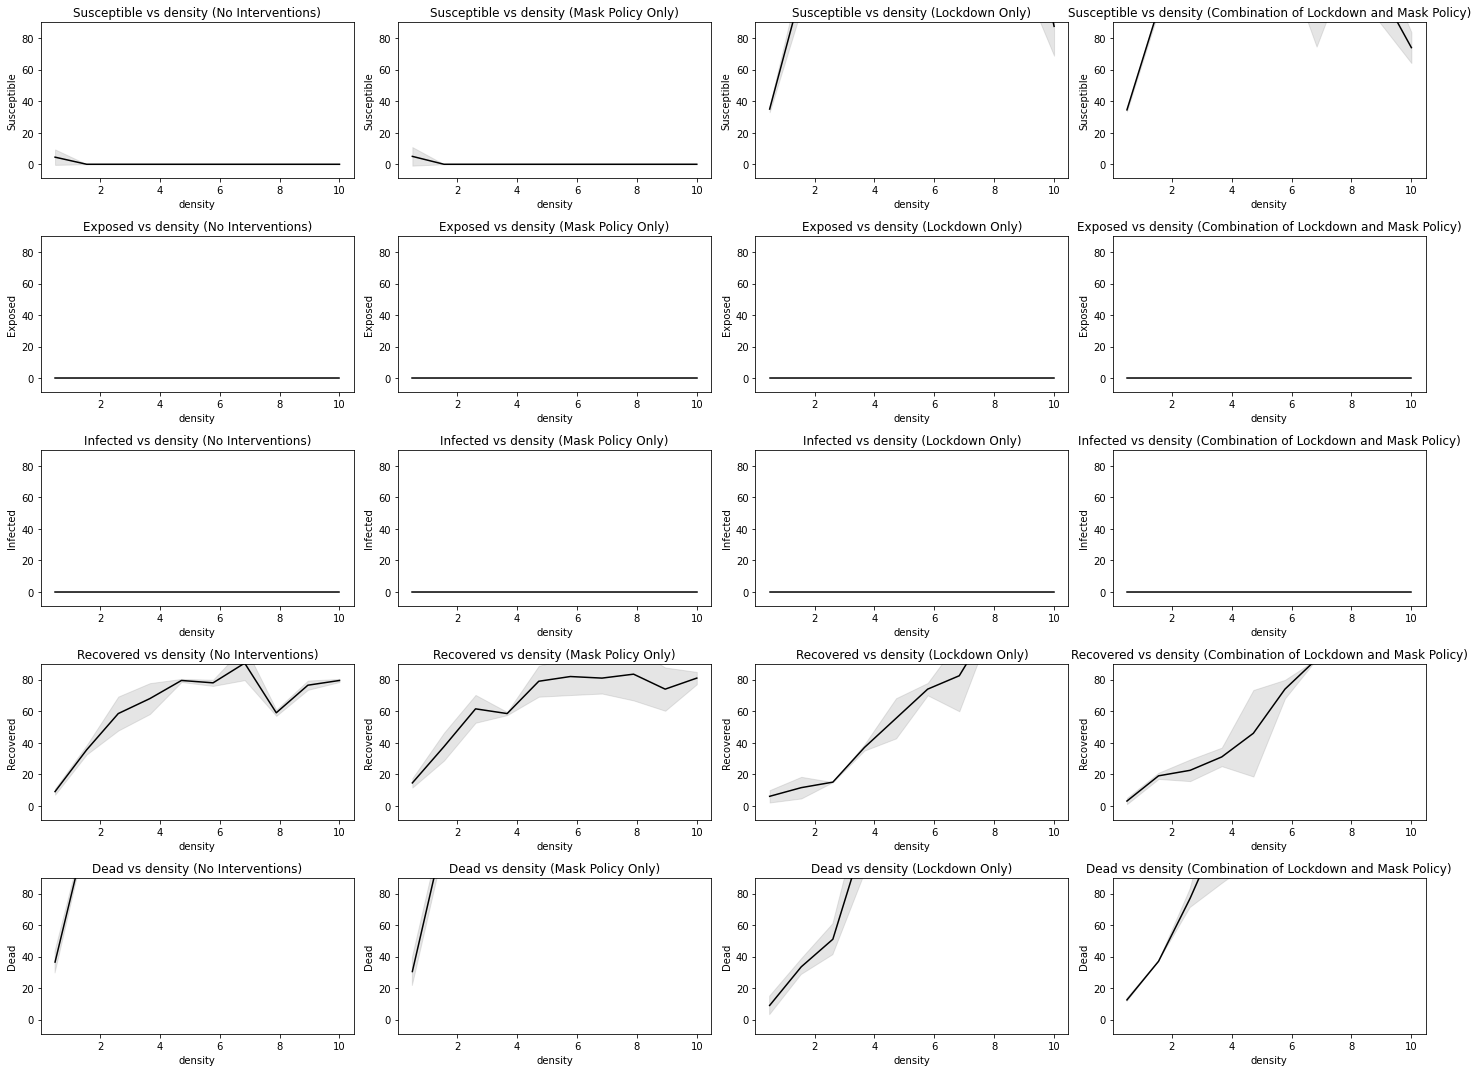

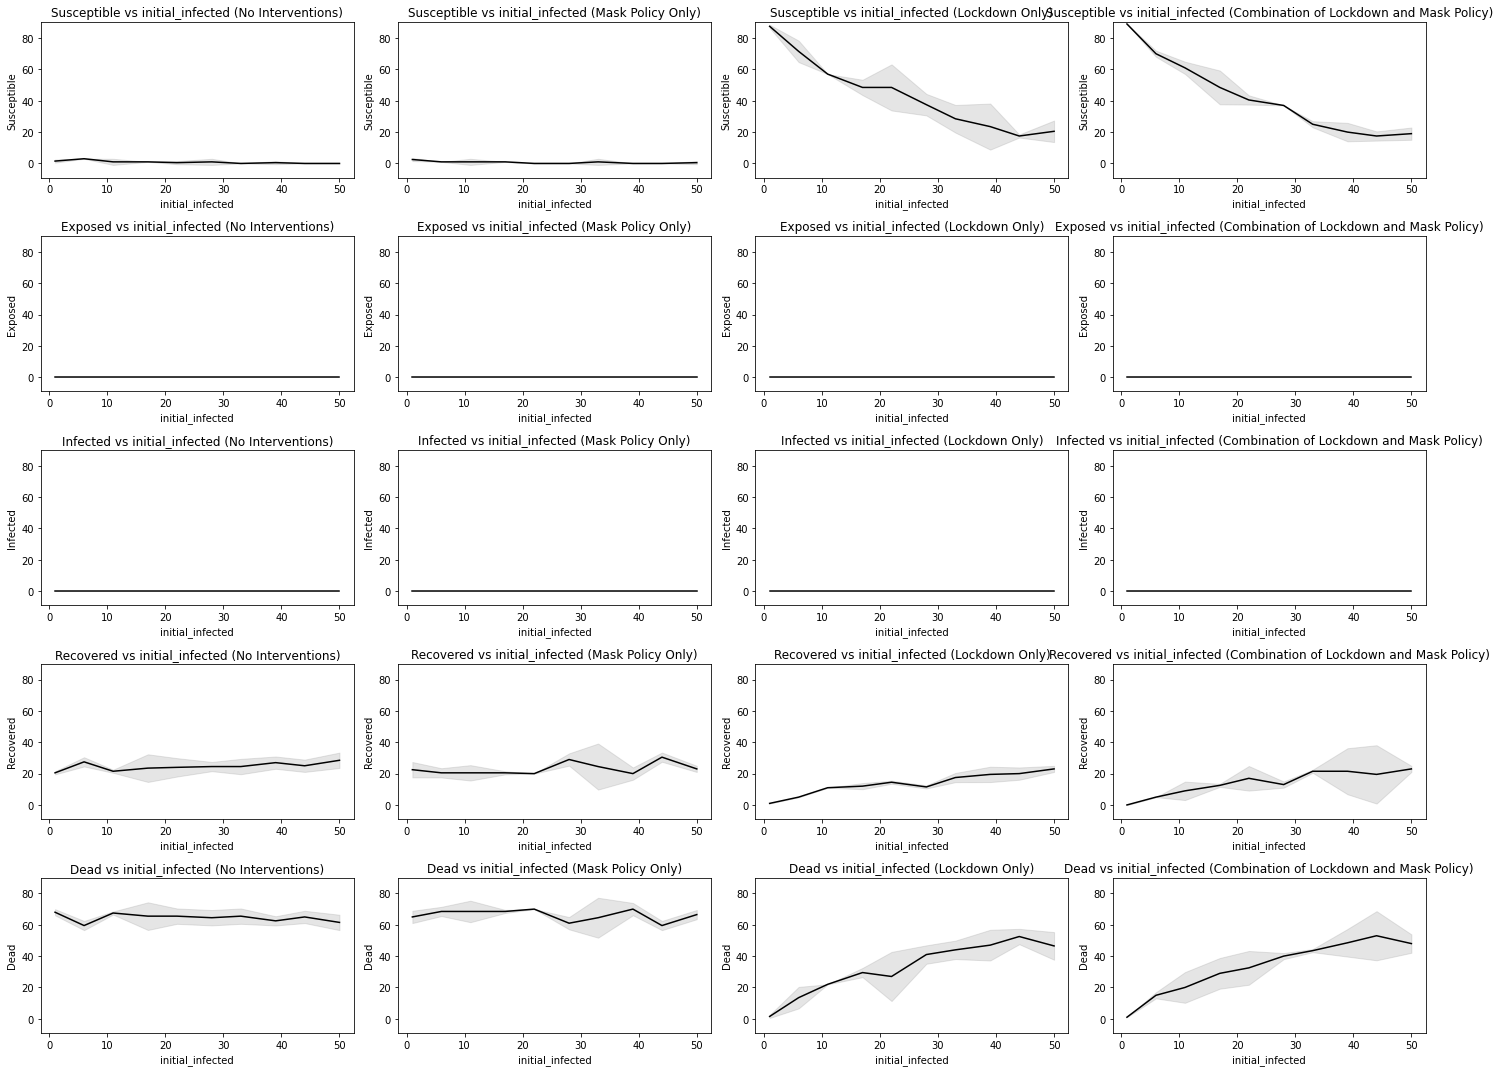

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mesa.batchrunner import BatchRunner
from Environment import SIERDModel

class CustomBatchRunner(BatchRunner):
    def run_model(self, model):
        for _ in range(self.max_steps):
            model.step()

# Define variables and bounds
problem = {
    'num_vars': 6,
    'names': ['transmission_rate', 'latency_period', 'infection_duration', 'recovery_rate', 'density', 'initial_infected'],
    'bounds': [[0.1, 1.0], [1, 30], [1, 60], [0.0, 1.0], [0.5, 10.0], [1, 50]]
}

# Set repetitions, steps, and distinct values per variable
replicates = 2
max_steps = 500
distinct_samples = 10

# Default density value
default_density = 0.9

# Calculate total number of agents based on default density
width = 10
height = 10
total_agents = width * height * default_density

# Correcting model_reporters to pass the correct arguments
model_reporters = {
    "Susceptible": lambda m: m.count_state(m, "Susceptible"),
    "Exposed": lambda m: m.count_state(m, "Exposed"),
    "Infected": lambda m: m.count_state(m, "Infected"),
    "Recovered": lambda m: m.count_state(m, "Recovered"),
    "Dead": lambda m: m.count_state(m, "Dead")
}

policies = ["No Interventions", "Mask Policy Only", "Lockdown Only", "Combination of Lockdown and Mask Policy"]
data = {policy: {} for policy in policies}

for policy in policies:
    for i, var in enumerate(problem['names']):
        samples = np.linspace(*problem['bounds'][i], num=distinct_samples)
        
        if var in ['latency_period', 'infection_duration', 'initial_infected']:
            samples = np.linspace(*problem['bounds'][i], num=distinct_samples, dtype=int)
        
        variable_parameters = {var: samples.tolist()}
        fixed_parameters = {
            "width": width,
            "height": height,
            "density": default_density,
            "transmission_rate": 0.6,
            "latency_period": 5,
            "infection_duration": 10,
            "recovery_rate": 0.3,
            "policy": policy,
            "num_districts": 5,
            "initial_infected": 10
        }

        # Ensure the specific variable parameter is updated in fixed_parameters
        del fixed_parameters[var]
        
        batch = CustomBatchRunner(
            SIERDModel,
            max_steps=max_steps,
            iterations=replicates,
            variable_parameters=variable_parameters,
            fixed_parameters=fixed_parameters,
            model_reporters=model_reporters
        )
        
        batch.run_all()
        
        data[policy][var] = batch.get_model_vars_dataframe()

# Plotting function for the current variable
def plot_current_var(df_dict, var, total_agents):
    f, axs = plt.subplots(len(model_reporters), len(df_dict), figsize=(20, 15))
    for i, (param, _) in enumerate(model_reporters.items()):
        for j, (policy, df) in enumerate(df_dict.items()):
            # Remove non-numeric columns
            numeric_df = df.select_dtypes(include=[np.number])
            
            x = numeric_df.groupby(var).mean().reset_index()[var]
            y = numeric_df.groupby(var).mean()[param]

            replicates = numeric_df.groupby(var)[param].count()
            err = (1.96 * numeric_df.groupby(var)[param].std()) / np.sqrt(replicates)

            axs[i, j].plot(x, y, c='k')
            axs[i, j].fill_between(x, y - err, y + err, color='gray', alpha=0.2)

            axs[i, j].set_xlabel(var)
            axs[i, j].set_ylabel(param)
            axs[i, j].set_ylim(bottom=-0.1 * total_agents, top=total_agents)  # Ensure y-axis starts just below zero and ends at total agents
            axs[i, j].set_title(f'{param} vs {var} ({policy})')
    
    plt.tight_layout()
    plt.show()

# Plot for each variable
for var in problem['names']:
    df_dict = {policy: data[policy][var] for policy in policies}
    plot_current_var(df_dict, var, total_agents)

In [2]:
# 加载CSV文件 这个用相对位置报错还没改🤔
results_no_interventions = pd.read_csv('/Users/haha/Downloads/ABM/Epi-Simulator/results/results_mask_policy_only.csv')
results_mask_policy_only = pd.read_csv('/Users/haha/Downloads/ABM/Epi-Simulator/results/results_mask_policy_only.csv')

# Calculate total deaths and population for no interventions
no_mask_deaths = results_no_interventions['Dead'].sum()
total_population = results_no_interventions['Susceptible'].sum() + results_no_interventions['Infected'].sum() + results_no_interventions['Exposed'].sum() + results_no_interventions['Recovered'].sum() + results_no_interventions['Dead'].sum()
no_mask_mortality_rate = no_mask_deaths / total_population

# Calculate total deaths and population for mask policy only
mask_deaths = results_mask_policy_only['Dead'].sum()
mask_population = results_mask_policy_only['Susceptible'].sum() + results_mask_policy_only['Infected'].sum() + results_mask_policy_only['Exposed'].sum() + results_mask_policy_only['Recovered'].sum() + results_mask_policy_only['Dead'].sum()
mask_mortality_rate = mask_deaths / mask_population

# DataFrame
data = {
    'Mask Wearing': ['No Mask', 'Mask'],
    'Mortality Rate': [no_mask_mortality_rate, mask_mortality_rate]
}

df = pd.DataFrame(data)

# Histogram
plt.figure(figsize=(10, 6))
plt.bar(df['Mask Wearing'], df['Mortality Rate'], color=['red', 'green'])
plt.xlabel('Mask Wearing')
plt.ylabel('Mortality Rate')
plt.title('Sensitivity Analysis: Impact of Mask Wearing on Mortality Rate')
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: '/Users/haha/Downloads/ABM/Epi-Simulator/results/results_mask_policy_only.csv'

In [3]:
# 加载CSV文件
results_no_interventions = pd.read_csv('/Users/haha/Downloads/ABM/Epi-Simulator/results/results_no_interventions.csv')
results_mask_policy_only = pd.read_csv('/Users/haha/Downloads/ABM/Epi-Simulator/results/results_mask_policy_only.csv')

# 计算不戴口罩的平均死亡率
no_mask_deaths = results_no_interventions['Dead'].sum()
total_population = results_no_interventions['Susceptible'].sum() + results_no_interventions['Infected'].sum() + results_no_interventions['Exposed'].sum() + results_no_interventions['Recovered'].sum() + results_no_interventions['Dead'].sum()
no_mask_mortality_rate = no_mask_deaths / total_population

# 计算戴口罩的平均死亡率
mask_deaths = results_mask_policy_only['Dead'].sum()
mask_population = results_mask_policy_only['Susceptible'].sum() + results_mask_policy_only['Infected'].sum() + results_mask_policy_only['Exposed'].sum() + results_mask_policy_only['Recovered'].sum() + results_mask_policy_only['Dead'].sum()
mask_mortality_rate = mask_deaths / mask_population

# 创建DataFrame
data = {
    'Mask Wearing': ['No Mask', 'Mask'],
    'Mortality Rate': [no_mask_mortality_rate, mask_mortality_rate]
}

df = pd.DataFrame(data)

# 生成柱状图
plt.figure(figsize=(10, 6))
plt.bar(df['Mask Wearing'], df['Mortality Rate'], color=['red', 'green'])
plt.xlabel('Mask Wearing')
plt.ylabel('Mortality Rate')
plt.title('Sensitivity Analysis: Impact of Mask Wearing on Mortality Rate')

# 调整y轴的比例尺
plt.ylim([min(df['Mortality Rate']) - 0.001, max(df['Mortality Rate']) + 0.001])

plt.show()


FileNotFoundError: [Errno 2] No such file or directory: '/Users/haha/Downloads/ABM/Epi-Simulator/results/results_no_interventions.csv'

# Sobol SA

## No Interventions

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mesa.batchrunner import BatchRunner
from SALib.sample import saltelli
from SALib.analyze import sobol
from itertools import combinations
from Environment import SIERDModel

class CustomBatchRunner(BatchRunner):
    def run_model(self, model):
        for _ in range(self.max_steps):
            model.step()

# Define variables and bounds
problem = {
    'num_vars': 6,
    'names': ['transmission_rate', 'latency_period', 'infection_duration', 'recovery_rate', 'density', 'initial_infected'],
    'bounds': [[0.1, 1.0], [1, 30], [1, 60], [0.1, 1.0], [1, 8], [1, 50]]
}

# Set repetitions, steps, and distinct values per variable
replicates = 10
max_steps = 500
distinct_samples = 1024  # Use a power of 2 for better convergence with Sobol

# Default density value
default_density = 8  

# Calculate total number of agents based on default density
width = 10
height = 10
total_agents = int(width * height * default_density)

# Correcting model_reporters to pass the correct arguments
model_reporters = {
    "Susceptible": lambda m: m.count_state(m, "Susceptible"),
    "Exposed": lambda m: m.count_state(m, "Exposed"),
    "Infected": lambda m: m.count_state(m, "Infected"),
    "Recovered": lambda m: m.count_state(m, "Recovered"),
    "Dead": lambda m: m.count_state(m, "Dead")
}

# Generate samples using Saltelli sampling method with calc_second_order=True
param_values = saltelli.sample(problem, distinct_samples, calc_second_order=True)
param_values = np.array(param_values)
for i, (low, high) in enumerate(problem['bounds']):
    param_values[:, i] = low + (high - low) * param_values[:, i]

data = pd.DataFrame(index=range(replicates * len(param_values)), columns=problem['names'] + ['Run'] + list(model_reporters.keys()))
count = 0

for i in range(replicates):
    for vals in param_values:
        # Convert certain parameters to integers
        vals = list(vals)
        vals[1] = int(vals[1])  # latency_period
        vals[2] = int(vals[2])  # infection_duration
        vals[5] = int(vals[5])  # initial_infected
        
        # Ensure initial_infected does not exceed total_agents
        if vals[5] > total_agents:
            vals[5] = total_agents
        
        variable_parameters = {name: val for name, val in zip(problem['names'], vals)}
        
        # Add fixed parameters for model initialization
        fixed_parameters = {
            "width": width,
            "height": height,
            "policy": "No Interventions",  # update this if needed
            "num_districts": 10
        }
        fixed_parameters.update(variable_parameters)
        
        batch.run_iteration(fixed_parameters, tuple(vals), count)
        iteration_data = batch.get_model_vars_dataframe().iloc[count]
        iteration_data['Run'] = count

        # Print iteration_data for debugging
        print(f"Debug iteration_data at count {count}:")
        print(iteration_data)
        print(f"Length of iteration_data: {len(iteration_data.values)}")
        
        # Ensure iteration_data matches the DataFrame structure
        data.iloc[count, :len(problem['names'])] = vals
        data.iloc[count, len(problem['names']):] = iteration_data.values
        count += 1

# Sobol analysis
Si_susceptible = sobol.analyze(problem, data['Susceptible'].values, calc_second_order=True, print_to_console=True)
Si_exposed = sobol.analyze(problem, data['Exposed'].values, calc_second_order=True, print_to_console=True)
Si_infected = sobol.analyze(problem, data['Infected'].values, calc_second_order=True, print_to_console=True)
Si_recovered = sobol.analyze(problem, data['Recovered'].values, calc_second_order=True, print_to_console=True)
Si_dead = sobol.analyze(problem, data['Dead'].values, calc_second_order=True, print_to_console=True)

def plot_sobol_indices(Si, params, i, title=''):
    """
    Creates a plot for Sobol sensitivity analysis showing the contributions
    of each parameter to the global sensitivity.

    Args:
        Si (dict): Dictionary of Sobol sensitivity indices.
        params (list): List of parameter names.
        i (str): Indicates the order of sensitivity (1, 2, or T).
        title (str): Title for the plot.
    """
    if i == '2':
        p = len(params)
        params = list(combinations(params, 2))
        indices = Si['S' + i].reshape((p ** 2))
        indices = indices[~np.isnan(indices)]
        errors = Si['S' + i + '_conf'].reshape((p ** 2))
        errors = errors[~np.isnan(errors)]
    else:
        indices = Si['S' + i]
        errors = Si['S' + i + '_conf']
        plt.figure()

    l = len(indices)

    plt.title(title)
    plt.ylim([-0.2, len(indices) - 1 + 0.2])
    plt.yticks(range(l), params)
    plt.errorbar(indices, range(l), xerr=errors, linestyle='None', marker='o')
    plt.axvline(0, c='k')
    plt.show()

for Si, output in zip([Si_susceptible, Si_exposed, Si_infected, Si_recovered, Si_dead], model_reporters.keys()):
    # First order sensitivity
    plot_sobol_indices(Si, problem['names'], '1', f'First order sensitivity for {output}')
    
    # Second order sensitivity
    plot_sobol_indices(Si, problem['names'], '2', f'Second order sensitivity for {output}')
    
    # Total order sensitivity
    plot_sobol_indices(Si, problem['names'], 'T', f'Total order sensitivity for {output}')


C:\Users\alext\AppData\Local\Temp\ipykernel_11836\481882030.py:45: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  param_values = saltelli.sample(problem, distinct_samples, calc_second_order=True)


Debug iteration_data at count 0:
Run             0.0
Dead            1.0
Exposed         0.0
Infected        0.0
Recovered       0.0
Susceptible    49.0
Name: 0, dtype: float64
Length of iteration_data: 6
Debug iteration_data at count 1:
Run             1.0
Dead            1.0
Exposed         0.0
Infected        0.0
Recovered       0.0
Susceptible    49.0
Name: 1440, dtype: float64
Length of iteration_data: 6
Debug iteration_data at count 2:
Run             2.0
Dead            1.0
Exposed         0.0
Infected        0.0
Recovered       0.0
Susceptible    49.0
Name: 1120, dtype: float64
Length of iteration_data: 6
Debug iteration_data at count 3:
Run             3.0
Dead            1.0
Exposed         0.0
Infected        0.0
Recovered       0.0
Susceptible    49.0
Name: 960, dtype: float64
Length of iteration_data: 6
Debug iteration_data at count 4:
Run             4.0
Dead            2.0
Exposed         0.0
Infected        0.0
Recovered       0.0
Susceptible    48.0
Name: 800, dtype: f

KeyboardInterrupt: 

## Mask Policy

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mesa.batchrunner import BatchRunner
from SALib.sample import saltelli
from SALib.analyze import sobol
from itertools import combinations
from Environment import SIERDModel

class CustomBatchRunner(BatchRunner):
    def run_model(self, model):
        for _ in range(self.max_steps):
            model.step()

# Define variables and bounds
problem = {
    'num_vars': 6,
    'names': ['transmission_rate', 'latency_period', 'infection_duration', 'recovery_rate', 'density', 'initial_infected'],
    'bounds': [[0.1, 1.0], [1, 30], [1, 60], [0.1, 1.0], [1, 8], [1, 50]]
}

# Set repetitions, steps, and distinct values per variable
replicates = 10
max_steps = 500
distinct_samples = 1024  # Use a power of 2 for better convergence with Sobol

# Default density value
default_density = 8  

# Calculate total number of agents based on default density
width = 10
height = 10
total_agents = int(width * height * default_density)

# Correcting model_reporters to pass the correct arguments
model_reporters = {
    "Susceptible": lambda m: m.count_state(m, "Susceptible"),
    "Exposed": lambda m: m.count_state(m, "Exposed"),
    "Infected": lambda m: m.count_state(m, "Infected"),
    "Recovered": lambda m: m.count_state(m, "Recovered"),
    "Dead": lambda m: m.count_state(m, "Dead")
}

# Generate samples using Saltelli sampling method with calc_second_order=True
param_values = saltelli.sample(problem, distinct_samples, calc_second_order=True)
param_values = np.array(param_values)
for i, (low, high) in enumerate(problem['bounds']):
    param_values[:, i] = low + (high - low) * param_values[:, i]

data = pd.DataFrame(index=range(replicates * len(param_values)), columns=problem['names'] + ['Run'] + list(model_reporters.keys()))
count = 0

for i in range(replicates):
    for vals in param_values:
        # Convert certain parameters to integers
        vals = list(vals)
        vals[1] = int(vals[1])  # latency_period
        vals[2] = int(vals[2])  # infection_duration
        vals[5] = int(vals[5])  # initial_infected
        
        # Ensure initial_infected does not exceed total_agents
        if vals[5] > total_agents:
            vals[5] = total_agents
        
        variable_parameters = {name: val for name, val in zip(problem['names'], vals)}
        
        # Add fixed parameters for model initialization
        fixed_parameters = {
            "width": width,
            "height": height,
            "policy": "Mask Policy Only",  # update this if needed
            "num_districts": 10
        }
        fixed_parameters.update(variable_parameters)
        
        batch.run_iteration(fixed_parameters, tuple(vals), count)
        iteration_data = batch.get_model_vars_dataframe().iloc[count]
        iteration_data['Run'] = count

        # Print iteration_data for debugging
        print(f"Debug iteration_data at count {count}:")
        print(iteration_data)
        print(f"Length of iteration_data: {len(iteration_data.values)}")
        
        # Ensure iteration_data matches the DataFrame structure
        data.iloc[count, :len(problem['names'])] = vals
        data.iloc[count, len(problem['names']):] = iteration_data.values
        count += 1

# Sobol analysis
Si_susceptible = sobol.analyze(problem, data['Susceptible'].values, calc_second_order=True, print_to_console=True)
Si_exposed = sobol.analyze(problem, data['Exposed'].values, calc_second_order=True, print_to_console=True)
Si_infected = sobol.analyze(problem, data['Infected'].values, calc_second_order=True, print_to_console=True)
Si_recovered = sobol.analyze(problem, data['Recovered'].values, calc_second_order=True, print_to_console=True)
Si_dead = sobol.analyze(problem, data['Dead'].values, calc_second_order=True, print_to_console=True)

def plot_sobol_indices(Si, params, i, title=''):
    """
    Creates a plot for Sobol sensitivity analysis showing the contributions
    of each parameter to the global sensitivity.

    Args:
        Si (dict): Dictionary of Sobol sensitivity indices.
        params (list): List of parameter names.
        i (str): Indicates the order of sensitivity (1, 2, or T).
        title (str): Title for the plot.
    """
    if i == '2':
        p = len(params)
        params = list(combinations(params, 2))
        indices = Si['S' + i].reshape((p ** 2))
        indices = indices[~np.isnan(indices)]
        errors = Si['S' + i + '_conf'].reshape((p ** 2))
        errors = errors[~np.isnan(errors)]
    else:
        indices = Si['S' + i]
        errors = Si['S' + i + '_conf']
        plt.figure()

    l = len(indices)

    plt.title(title)
    plt.ylim([-0.2, len(indices) - 1 + 0.2])
    plt.yticks(range(l), params)
    plt.errorbar(indices, range(l), xerr=errors, linestyle='None', marker='o')
    plt.axvline(0, c='k')
    plt.show()

for Si, output in zip([Si_susceptible, Si_exposed, Si_infected, Si_recovered, Si_dead], model_reporters.keys()):
    # First order sensitivity
    plot_sobol_indices(Si, problem['names'], '1', f'First order sensitivity for {output}')
    
    # Second order sensitivity
    plot_sobol_indices(Si, problem['names'], '2', f'Second order sensitivity for {output}')
    
    # Total order sensitivity
    plot_sobol_indices(Si, problem['names'], 'T', f'Total order sensitivity for {output}')

## Lockdown Policy

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mesa.batchrunner import BatchRunner
from SALib.sample import saltelli
from SALib.analyze import sobol
from itertools import combinations
from Environment import SIERDModel

class CustomBatchRunner(BatchRunner):
    def run_model(self, model):
        for _ in range(self.max_steps):
            model.step()

# Define variables and bounds
problem = {
    'num_vars': 6,
    'names': ['transmission_rate', 'latency_period', 'infection_duration', 'recovery_rate', 'density', 'initial_infected'],
    'bounds': [[0.1, 1.0], [1, 30], [1, 60], [0.1, 1.0], [1, 8], [1, 50]]
}

# Set repetitions, steps, and distinct values per variable
replicates = 10
max_steps = 500
distinct_samples = 1024  # Use a power of 2 for better convergence with Sobol

# Default density value
default_density = 8  

# Calculate total number of agents based on default density
width = 10
height = 10
total_agents = int(width * height * default_density)

# Correcting model_reporters to pass the correct arguments
model_reporters = {
    "Susceptible": lambda m: m.count_state(m, "Susceptible"),
    "Exposed": lambda m: m.count_state(m, "Exposed"),
    "Infected": lambda m: m.count_state(m, "Infected"),
    "Recovered": lambda m: m.count_state(m, "Recovered"),
    "Dead": lambda m: m.count_state(m, "Dead")
}

# Generate samples using Saltelli sampling method with calc_second_order=True
param_values = saltelli.sample(problem, distinct_samples, calc_second_order=True)
param_values = np.array(param_values)
for i, (low, high) in enumerate(problem['bounds']):
    param_values[:, i] = low + (high - low) * param_values[:, i]

data = pd.DataFrame(index=range(replicates * len(param_values)), columns=problem['names'] + ['Run'] + list(model_reporters.keys()))
count = 0

for i in range(replicates):
    for vals in param_values:
        # Convert certain parameters to integers
        vals = list(vals)
        vals[1] = int(vals[1])  # latency_period
        vals[2] = int(vals[2])  # infection_duration
        vals[5] = int(vals[5])  # initial_infected
        
        # Ensure initial_infected does not exceed total_agents
        if vals[5] > total_agents:
            vals[5] = total_agents
        
        variable_parameters = {name: val for name, val in zip(problem['names'], vals)}
        
        # Add fixed parameters for model initialization
        fixed_parameters = {
            "width": width,
            "height": height,
            "policy": "Lockdown Only",  # update this if needed
            "num_districts": 10
        }
        fixed_parameters.update(variable_parameters)
        
        batch.run_iteration(fixed_parameters, tuple(vals), count)
        iteration_data = batch.get_model_vars_dataframe().iloc[count]
        iteration_data['Run'] = count

        # Print iteration_data for debugging
        print(f"Debug iteration_data at count {count}:")
        print(iteration_data)
        print(f"Length of iteration_data: {len(iteration_data.values)}")
        
        # Ensure iteration_data matches the DataFrame structure
        data.iloc[count, :len(problem['names'])] = vals
        data.iloc[count, len(problem['names']):] = iteration_data.values
        count += 1

# Sobol analysis
Si_susceptible = sobol.analyze(problem, data['Susceptible'].values, calc_second_order=True, print_to_console=True)
Si_exposed = sobol.analyze(problem, data['Exposed'].values, calc_second_order=True, print_to_console=True)
Si_infected = sobol.analyze(problem, data['Infected'].values, calc_second_order=True, print_to_console=True)
Si_recovered = sobol.analyze(problem, data['Recovered'].values, calc_second_order=True, print_to_console=True)
Si_dead = sobol.analyze(problem, data['Dead'].values, calc_second_order=True, print_to_console=True)

def plot_sobol_indices(Si, params, i, title=''):
    """
    Creates a plot for Sobol sensitivity analysis showing the contributions
    of each parameter to the global sensitivity.

    Args:
        Si (dict): Dictionary of Sobol sensitivity indices.
        params (list): List of parameter names.
        i (str): Indicates the order of sensitivity (1, 2, or T).
        title (str): Title for the plot.
    """
    if i == '2':
        p = len(params)
        params = list(combinations(params, 2))
        indices = Si['S' + i].reshape((p ** 2))
        indices = indices[~np.isnan(indices)]
        errors = Si['S' + i + '_conf'].reshape((p ** 2))
        errors = errors[~np.isnan(errors)]
    else:
        indices = Si['S' + i]
        errors = Si['S' + i + '_conf']
        plt.figure()

    l = len(indices)

    plt.title(title)
    plt.ylim([-0.2, len(indices) - 1 + 0.2])
    plt.yticks(range(l), params)
    plt.errorbar(indices, range(l), xerr=errors, linestyle='None', marker='o')
    plt.axvline(0, c='k')
    plt.show()

for Si, output in zip([Si_susceptible, Si_exposed, Si_infected, Si_recovered, Si_dead], model_reporters.keys()):
    # First order sensitivity
    plot_sobol_indices(Si, problem['names'], '1', f'First order sensitivity for {output}')
    
    # Second order sensitivity
    plot_sobol_indices(Si, problem['names'], '2', f'Second order sensitivity for {output}')
    
    # Total order sensitivity
    plot_sobol_indices(Si, problem['names'], 'T', f'Total order sensitivity for {output}')

## Combination

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mesa.batchrunner import BatchRunner
from SALib.sample import saltelli
from SALib.analyze import sobol
from itertools import combinations
from Environment import SIERDModel

class CustomBatchRunner(BatchRunner):
    def run_model(self, model):
        for _ in range(self.max_steps):
            model.step()

# Define variables and bounds
problem = {
    'num_vars': 6,
    'names': ['transmission_rate', 'latency_period', 'infection_duration', 'recovery_rate', 'density', 'initial_infected'],
    'bounds': [[0.1, 1.0], [1, 30], [1, 60], [0.1, 1.0], [1, 8], [1, 50]]
}

# Set repetitions, steps, and distinct values per variable
replicates = 10
max_steps = 500
distinct_samples = 1024  # Use a power of 2 for better convergence with Sobol

# Default density value
default_density = 8  

# Calculate total number of agents based on default density
width = 10
height = 10
total_agents = int(width * height * default_density)

# Correcting model_reporters to pass the correct arguments
model_reporters = {
    "Susceptible": lambda m: m.count_state(m, "Susceptible"),
    "Exposed": lambda m: m.count_state(m, "Exposed"),
    "Infected": lambda m: m.count_state(m, "Infected"),
    "Recovered": lambda m: m.count_state(m, "Recovered"),
    "Dead": lambda m: m.count_state(m, "Dead")
}

# Generate samples using Saltelli sampling method with calc_second_order=True
param_values = saltelli.sample(problem, distinct_samples, calc_second_order=True)
param_values = np.array(param_values)
for i, (low, high) in enumerate(problem['bounds']):
    param_values[:, i] = low + (high - low) * param_values[:, i]

data = pd.DataFrame(index=range(replicates * len(param_values)), columns=problem['names'] + ['Run'] + list(model_reporters.keys()))
count = 0

for i in range(replicates):
    for vals in param_values:
        # Convert certain parameters to integers
        vals = list(vals)
        vals[1] = int(vals[1])  # latency_period
        vals[2] = int(vals[2])  # infection_duration
        vals[5] = int(vals[5])  # initial_infected
        
        # Ensure initial_infected does not exceed total_agents
        if vals[5] > total_agents:
            vals[5] = total_agents
        
        variable_parameters = {name: val for name, val in zip(problem['names'], vals)}
        
        # Add fixed parameters for model initialization
        fixed_parameters = {
            "width": width,
            "height": height,
            "policy": "Combination of Lockdown and Mask Policy",  # update this if needed
            "num_districts": 10
        }
        fixed_parameters.update(variable_parameters)
        
        batch.run_iteration(fixed_parameters, tuple(vals), count)
        iteration_data = batch.get_model_vars_dataframe().iloc[count]
        iteration_data['Run'] = count

        # Print iteration_data for debugging
        print(f"Debug iteration_data at count {count}:")
        print(iteration_data)
        print(f"Length of iteration_data: {len(iteration_data.values)}")
        
        # Ensure iteration_data matches the DataFrame structure
        data.iloc[count, :len(problem['names'])] = vals
        data.iloc[count, len(problem['names']):] = iteration_data.values
        count += 1

# Sobol analysis
Si_susceptible = sobol.analyze(problem, data['Susceptible'].values, calc_second_order=True, print_to_console=True)
Si_exposed = sobol.analyze(problem, data['Exposed'].values, calc_second_order=True, print_to_console=True)
Si_infected = sobol.analyze(problem, data['Infected'].values, calc_second_order=True, print_to_console=True)
Si_recovered = sobol.analyze(problem, data['Recovered'].values, calc_second_order=True, print_to_console=True)
Si_dead = sobol.analyze(problem, data['Dead'].values, calc_second_order=True, print_to_console=True)

def plot_sobol_indices(Si, params, i, title=''):
    """
    Creates a plot for Sobol sensitivity analysis showing the contributions
    of each parameter to the global sensitivity.

    Args:
        Si (dict): Dictionary of Sobol sensitivity indices.
        params (list): List of parameter names.
        i (str): Indicates the order of sensitivity (1, 2, or T).
        title (str): Title for the plot.
    """
    if i == '2':
        p = len(params)
        params = list(combinations(params, 2))
        indices = Si['S' + i].reshape((p ** 2))
        indices = indices[~np.isnan(indices)]
        errors = Si['S' + i + '_conf'].reshape((p ** 2))
        errors = errors[~np.isnan(errors)]
    else:
        indices = Si['S' + i]
        errors = Si['S' + i + '_conf']
        plt.figure()

    l = len(indices)

    plt.title(title)
    plt.ylim([-0.2, len(indices) - 1 + 0.2])
    plt.yticks(range(l), params)
    plt.errorbar(indices, range(l), xerr=errors, linestyle='None', marker='o')
    plt.axvline(0, c='k')
    plt.show()

for Si, output in zip([Si_susceptible, Si_exposed, Si_infected, Si_recovered, Si_dead], model_reporters.keys()):
    # First order sensitivity
    plot_sobol_indices(Si, problem['names'], '1', f'First order sensitivity for {output}')
    
    # Second order sensitivity
    plot_sobol_indices(Si, problem['names'], '2', f'Second order sensitivity for {output}')
    
    # Total order sensitivity
    plot_sobol_indices(Si, problem['names'], 'T', f'Total order sensitivity for {output}')

## Mayor Policy (district = 10)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mesa.batchrunner import BatchRunner
from SALib.sample import saltelli
from SALib.analyze import sobol
from itertools import combinations
from Environment import SIERDModel

class CustomBatchRunner(BatchRunner):
    def run_model(self, model):
        for _ in range(self.max_steps):
            model.step()

# Define variables and bounds
problem = {
    'num_vars': 6,
    'names': ['transmission_rate', 'latency_period', 'infection_duration', 'recovery_rate', 'density', 'initial_infected'],
    'bounds': [[0.1, 1.0], [1, 30], [1, 60], [0.1, 1.0], [1, 8], [1, 50]]
}

# Set repetitions, steps, and distinct values per variable
replicates = 10
max_steps = 500
distinct_samples = 1024  # Use a power of 2 for better convergence with Sobol

# Default density value
default_density = 8  

# Calculate total number of agents based on default density
width = 10
height = 10
total_agents = int(width * height * default_density)

# Correcting model_reporters to pass the correct arguments
model_reporters = {
    "Susceptible": lambda m: m.count_state(m, "Susceptible"),
    "Exposed": lambda m: m.count_state(m, "Exposed"),
    "Infected": lambda m: m.count_state(m, "Infected"),
    "Recovered": lambda m: m.count_state(m, "Recovered"),
    "Dead": lambda m: m.count_state(m, "Dead")
}

# Generate samples using Saltelli sampling method with calc_second_order=True
param_values = saltelli.sample(problem, distinct_samples, calc_second_order=True)
param_values = np.array(param_values)
for i, (low, high) in enumerate(problem['bounds']):
    param_values[:, i] = low + (high - low) * param_values[:, i]

data = pd.DataFrame(index=range(replicates * len(param_values)), columns=problem['names'] + ['Run'] + list(model_reporters.keys()))
count = 0

for i in range(replicates):
    for vals in param_values:
        # Convert certain parameters to integers
        vals = list(vals)
        vals[1] = int(vals[1])  # latency_period
        vals[2] = int(vals[2])  # infection_duration
        vals[5] = int(vals[5])  # initial_infected
        
        # Ensure initial_infected does not exceed total_agents
        if vals[5] > total_agents:
            vals[5] = total_agents
        
        variable_parameters = {name: val for name, val in zip(problem['names'], vals)}
        
        # Add fixed parameters for model initialization
        fixed_parameters = {
            "width": width,
            "height": height,
            "policy": "Mayor",  # update this if needed
            "num_districts": 10
        }
        fixed_parameters.update(variable_parameters)
        
        batch.run_iteration(fixed_parameters, tuple(vals), count)
        iteration_data = batch.get_model_vars_dataframe().iloc[count]
        iteration_data['Run'] = count

        # Print iteration_data for debugging
        print(f"Debug iteration_data at count {count}:")
        print(iteration_data)
        print(f"Length of iteration_data: {len(iteration_data.values)}")
        
        # Ensure iteration_data matches the DataFrame structure
        data.iloc[count, :len(problem['names'])] = vals
        data.iloc[count, len(problem['names']):] = iteration_data.values
        count += 1

# Sobol analysis
Si_susceptible = sobol.analyze(problem, data['Susceptible'].values, calc_second_order=True, print_to_console=True)
Si_exposed = sobol.analyze(problem, data['Exposed'].values, calc_second_order=True, print_to_console=True)
Si_infected = sobol.analyze(problem, data['Infected'].values, calc_second_order=True, print_to_console=True)
Si_recovered = sobol.analyze(problem, data['Recovered'].values, calc_second_order=True, print_to_console=True)
Si_dead = sobol.analyze(problem, data['Dead'].values, calc_second_order=True, print_to_console=True)

def plot_sobol_indices(Si, params, i, title=''):
    """
    Creates a plot for Sobol sensitivity analysis showing the contributions
    of each parameter to the global sensitivity.

    Args:
        Si (dict): Dictionary of Sobol sensitivity indices.
        params (list): List of parameter names.
        i (str): Indicates the order of sensitivity (1, 2, or T).
        title (str): Title for the plot.
    """
    if i == '2':
        p = len(params)
        params = list(combinations(params, 2))
        indices = Si['S' + i].reshape((p ** 2))
        indices = indices[~np.isnan(indices)]
        errors = Si['S' + i + '_conf'].reshape((p ** 2))
        errors = errors[~np.isnan(errors)]
    else:
        indices = Si['S' + i]
        errors = Si['S' + i + '_conf']
        plt.figure()

    l = len(indices)

    plt.title(title)
    plt.ylim([-0.2, len(indices) - 1 + 0.2])
    plt.yticks(range(l), params)
    plt.errorbar(indices, range(l), xerr=errors, linestyle='None', marker='o')
    plt.axvline(0, c='k')
    plt.show()

for Si, output in zip([Si_susceptible, Si_exposed, Si_infected, Si_recovered, Si_dead], model_reporters.keys()):
    # First order sensitivity
    plot_sobol_indices(Si, problem['names'], '1', f'First order sensitivity for {output}')
    
    # Second order sensitivity
    plot_sobol_indices(Si, problem['names'], '2', f'Second order sensitivity for {output}')
    
    # Total order sensitivity
    plot_sobol_indices(Si, problem['names'], 'T', f'Total order sensitivity for {output}')